## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
grp1 = df.query("landing_page == 'new_page' and group == 'control'")
grp2 = df.query("landing_page == 'old_page' and group == 'treatment'")
grp1.count() + grp2.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**As we can see, there are no missing values**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.copy()
df2.drop(grp1.index.values, inplace=True)
df2.drop(grp2.index.values, inplace=True)
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

773192

c. What is the row information for the repeat **user_id**? 

In [11]:
df2[df2.duplicated('user_id', keep=False) == True]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop(df.index[2893], axis=0, inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2.query("group== 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2.query("group== 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [16]:
ind = df2.query('landing_page == "new_page"')
ind_df = ind['converted'].count()
ind_df/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**From the above analysis, we can see the conversion rate of both the pages. Looking at the conversion rates, we can see that they are close (approximately 12% for the Control group and 11.9% for the Treatment group), thus we cannot conclude that the new treatment page leads to more conversion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

*I want to assume that the old page is better, unless the new page proves to be definitely better at a Type I error rate of 5%. My null and alternative hypothesis are provided below:*

Null: **$p_{new}$** <= **$p_{old}$**

Alternative: **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [18]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [20]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_new])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
new_page_converted.mean() - old_page_converted.mean()

0.0023035580992120663

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
p_diffs = []
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted 
p_diffs

array([ 0.00110575,  0.00056918,  0.00098884, ...,  0.00010817,
        0.00127819, -0.00082814])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

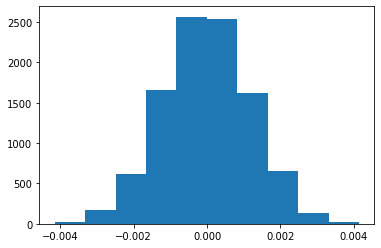

In [25]:
plt.hist(p_diffs);

**The plot looks exactly as i expected. It is a Normal Distribution.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff

-0.0015782389853555567

In [27]:
#Convert to Numpy array
p_diffs = np.array(p_diffs)
p_val = (p_diffs > actual_diff).mean()
p_val #p-value

0.9067

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The formula I computed in j is called the P-VALUE, which is the probability of observing this statistics (or one more extreme in favor of the alternative) if the null hypothesis is true. The P-Value above is 0.9067 which is large. We therefore stick to our null hypothesis.
Based on the data, we fail to reject the Null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [44]:
z_score, p_val = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old])
z_score, p_val

(-1.3109241984234394, 0.18988337448195103)

In [45]:
from scipy.stats import norm
print(norm.cdf(z_score)) # Tells us how significant our z-score is
print(norm.ppf(1-(0.05/2))) # Tells us what our critical value at 95% confidence

0.09494168724097551
1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**As we saw above, the z-score is approximately -1.31 and the p-value is 0.1899. We saw that the critical value above is 1.96, which is greater than the value of z-score we computed above. This means the z-score and p-value agree with the findings in parts j and k. Therefore, we cannot reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I would use Logistic Regression since we are predicting only two possible outcomes**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [46]:
df2['intercept'] = 1
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  treatment  control  ab_page  
0          1          1        0        1  
1          1          1        0        1  
2          1          0        1        0  
3          1          0        1        0  
4          1          1        0        1

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [47]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:23:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.1899. This p-value differs from the value I found in Part II because they have different hypothesis. Also, a two-tailed test was performed in part III while a one-tailed test was performed in part II, hence the big difference between the two p-values.**

**The Part II Hypothesis is**

Null: **$p_{new}$** <= **$p_{old}$**

Alternative: **$p_{new}$** > **$p_{old}$**

**The Part III(Regression Model) Hypothesis is**

Null: **$p_{new}$** = **$p_{old}$**

Alternative: **$p_{new}$** != **$p_{old}$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors to add into my regression model.Adding a relevant variable can prevent bias in the estimate of the other regression coefficient but can also increase variance of other regression coefficient.There are many factors that may effect result. We have to consider them or else our result will be not correct.Some disadvantages to adding additional terms into my regression model include correlation errors, non-constant variance, outliers, multicollinearity among others.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [49]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

In [50]:
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  treatment  control  ab_page  
user_id                                                     
834778           0          1          1        0        1  
928468           0          1          0        1        0  
822059           1          1          0        1        0  
711597           0          1          1        0        1  
710616           0          1          0        1        0

In [51]:
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3['country'])

In [52]:
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','US', 'UK']])
results = logit_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:30:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Since the p-value above are all greater than the type I error rate(0.05),we are going to retain the null hypothesis**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
df3['group_country'] = df3['group'] + '_' + df3['country']
df3.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  treatment  control  ab_page  US  UK  CA  \
user_id                                                                  
834778           0          1          1        0        1   0   1   0   
928468           0          1          0        1        0   0   0   1   
822059           1          1          0        1        0   0   1   0   
711597           0          1          1        0        1   0   1   0   
710616           0          1          0        1        0   0   1   0   

        group_country  
user_id                
834778     control_UK  
928468   treatment_US  
822059   treatment_UK  
711597     control_UK  
710616   treatment_UK

In [54]:
df3 = df3.join(pd.get_dummies(df3['group_country']))
df3.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  treatment  control  ab_page  US  UK  CA  \
user_id                                                                  
834778           0          1          1        0        1   0   1   0   
928468           0          1          0        1        0   0   0   1   
822059           1          1          0        1        0   0   1   0   
711597           0          1          1        0        1   0   1   0   
710616           0          1          0        1        0   0   1   0   

        group_country  control_CA  control_UK  control_US  treatment_CA  \
user_id                                                                   
834778     control_UK           0           1           0             0   
928468   treatment_US           0           0           0             0   
822059   treatment_UK           0           0           0             0   
711597     control_UK           0           1           0             0   
710616   treatment_UK           0           0           0             0   

         treatment_UK  treatment_US  
user_id                              
834778              0             0  
928468              0             1  
822059              1             0  
711597              0             0  
710616              1             0

In [55]:
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'treatment_CA', 'treatment_UK']])
results = logit_mod3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        23:32:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -2.0246      0.039    -52.034      0.000      -2.101      -1.948
ab_page          0.0206      0.014      1.505      0.132      -0.006       0.047
CA               0.0175      0.038      0.465      0.642      -0.056       0.091
UK               0.0118      0.040      0.296      0.767      -0.066       0.090
treatment_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
treatment_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
================================================================================
"""

**From the above result, we can clearly saw that all the p-values are greater than 0.05. Therefore, we can say that there is no significant effects on conversions between page and country.**

<a id='conclusions'></a>
## Conclusion
In this experiment, I aimed at finding whether the help the company understand if they should implement the new web page or keep the old web page. My null hypothesis was that the old page has the same or even higher converted rate than the new page, and our alternative hypothesis was that the old page has lower converted rate than the new page.

I performed an A/B test by using Simulating from the Null and calculating the Z-score. Both methods led to the same conclusion of retaining the null hypothesis.

I then performed regression approach by fitting a logistic regression model. Although the p-value is different from what we got in the A/B test due to different null and alternative hypotheses and a two-tailed test was performed in part III whole a one-tailed test was performed in part II. The result provided by the regression model agreed with the results in the A/B test.

Finally, I read a new dataset- Countries.csv to add an effect based into the regression model, which is the country a user lives. I looked at the individual factors and the interaction of country and landing page to see if they have significant effects on conversion. The results showed that the factors of landing page and country do not have significant effect on the converted rate individually and interactively.